# Trabalho Prático

**Integrantes:** Marco Antonio Oliari e Maria Luiza Armini

**Matrícula:** 2018102549 e 2019108672

**email:**  marco.oliari@edu.ufes.br e maria.l.correa@edu.ufes.br

# Motivação e Objetivo

A partir da base dados fornecida pelo professor, pretende-se entender se é possível identificar relações entre as descrições de livros e o gênero literário correspondente, explorando principalmente cada palavra de maneira individual, considerando sua frequência de aparição.

# Obtenção dos Dados

Os dados são obtidos diretamente do diretório criado no Google Drive, e transformados para DataFrames do módulo pandas, facilitando assim posterior manipulação e tratamento destes.

In [ ]:
import sys
!{sys.executable} -m pip install gdown

In [ ]:
import pandas as pd
import gdown
import os

In [ ]:
DIR = 'drive/My Drive/DS/Trabalho_Pratico'

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
pip install unidecode

## Carregamento dos dados

Para cada livro contido dentro de um arquivo de entrada, deve-se verificar seu idioma, de forma que apenas livros escritos em inglês façam parte da análise. Escolheu-se também um número limite de informações a constituir o dataframe (2000 livros por gênero), com o intuito de evitar grandes exigências de hardware. Visto isso, a entrada de um dado na base de análise também é condicionada a uma descrição não vazia, buscando assim livros que possam agregar à análise de relação entre a descrição e o gênero.

In [ ]:
import gzip
import json
import random

def load_data(path, book_gender):
    data = []
    accepted_languages = ['en', 'eng', 'en-GB', 'en-US', 'en-CA']
    count = 0

    file_path = os.path.join(path, ('in/goodreads_books_' + book_gender + '.json.gz'))

    f = gzip.open(file_path)
    n_lines = sum(1 for _ in gzip.open(file_path))

    lines = f.read().splitlines()

    samples_size = 2000

    samples = random.sample(lines, n_lines)

    for line in samples:
        d = json.loads(line)

        if d['language_code'] in accepted_languages and d['description']:
              # apenas as informações relevantes à análise são retornadas
              data.append({
                  'book_id': d['book_id'],
                  'language_code': d['language_code'],
                  'description': d['description'],
                  'label': book_gender
              })

              count += 1

        if count == samples_size:
            break

    print('Done ' + book_gender)
    return data

Para cada gênero literário abre-se um arquivo e lê-se os jsons fornecidos. Logo em seguida, o retorno da função é transformado em um DataFrame e inserido em uma lista, que ao final das iterações contém todos os dados que serão utilizados na análise.

In [ ]:
from sklearn.model_selection import train_test_split

paths = ['children', 'comics_graphic', 'fantasy_paranormal', 'history_biography',
         'mystery_thriller_crime', 'poetry', 'romance', 'young_adult']

samples = []

for path in paths:
  books = pd.DataFrame(load_data(DIR, path))
  samples.append(books)
  del(books)


Done children
Done comics_graphic
Done fantasy_paranormal
Done history_biography
Done mystery_thriller_crime
Done poetry
Done romance
Done young_adult


Os DataFrames são unificados, gerando assim uma base de dados de todos os livros a serem analisados, contendo o id (``book_id``), o código da sua linguagem (``language_code``), a descrição (``description``) e o ``label`` identificando o gênero.

In [ ]:
samples = pd.concat(samples)

samples

,book_id,language_code,description,label
0,266794,en-GB,Ellie has a boyfriend! Interested in her - not...,children
1,935696,eng,A charming retelling of this magical tale of p...,children
2,153865,en-GB,George and Harold are up to their usual tricks...,children
3,13134117,eng,"It's Halloween on Deckawoo Drive, and Mr. and ...",children
4,412128,eng,Jessica Wakefield doesn't know how she'll surv...,children
...,...,...,...,...
1995,6766147,eng,"At a young age, Lil J. Skin started stealing p...",young_adult
1996,17924724,en-US,A ruthless murder and a stolen shipment of gol...,young_adult
1997,18284908,eng,It's a night like any other on board the Icaru...,young_adult
1998,389535,eng,"Like father, like son.\nIntelligent, popular, ...",young_adult


# Pré-Processamento dos Dados

O pré-processamento dos dados é iniciado separando as frases em tokens, estes que serão a peça chave de toda a análise:

In [ ]:
from nltk import sent_tokenize, word_tokenize
import nltk
nltk.download('punkt')
samples['description'] = samples['description'].apply(word_tokenize)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Os tokens são convertidos para letras minúsculas, eliminando a distinção entre maiúsculas e minúsculas:

In [ ]:
samples['description'] = samples['description'].apply(lambda tokens: [w.lower() for w in tokens])

Remove-se os caracteres de pontuação dos tokens, para que não influenciem diretamente no resultado:

In [ ]:
import string
table = str.maketrans('', '', string.punctuation)
samples['description'] = samples['description'].apply(lambda tokens: [w.translate(table) for w in tokens])

Visto que os livros são escritos na língua inglesa, são removidos os caracteres especiais para evitar possíveis distorções:

In [ ]:
import unidecode
samples['description'] = samples['description'].apply(lambda tokens: [unidecode.unidecode(w) for w in tokens])

Remove-se também os caracteres que não são palavras:

In [ ]:
samples['description'] = samples['description'].apply(lambda tokens: [word for word in tokens if word.isalpha()])
samples['description']

0       [ellie, has, a, boyfriend, interested, in, her...
1       [a, charming, retelling, of, this, magical, ta...
2       [george, and, harold, are, up, to, their, usua...
3       [it, s, halloween, on, deckawoo, drive, and, m...
4       [jessica, wakefield, does, nt, know, how, she,...
                              ...                        
1995    [at, a, young, age, lil, j, skin, started, ste...
1996    [a, ruthless, murder, and, a, stolen, shipment...
1997    [it, s, a, night, like, any, other, on, board,...
1998    [like, father, like, son, intelligent, popular...
1999    [in, a, world, not, divided, by, race, creed, ...
Name: description, Length: 16000, dtype: object

As stop words são palavras comuns dentro de uma língua, como artigos e pronomes. Com isso, acredita-se que a presença ou ausência delas não contribui no agrupamento a ser realizado, portanto também são removidas:

In [ ]:
nltk.download('punkt')
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
samples['description'] = samples['description'].apply(lambda words: [word for word in words if not word in stop_words])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Nesse ponto, já conseguimos visualizar de maneira interessante os dados que trabalharemos. Com auxílio de uma nuvem de palavras, podemos identificar as palavras mais frequentes:

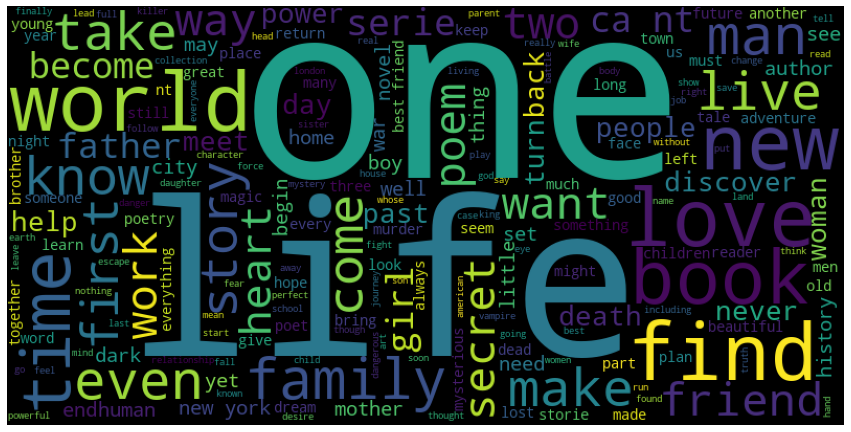

In [ ]:
#@title 
import matplotlib.pyplot as plt
from wordcloud import WordCloud

unique_string = (" ").join(samples.description.sum())
wordcloud = WordCloud(width=800, height=400).generate(unique_string)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()
plt.close()

Por último, aplica-se o stemming, reduzindo palavras flexionadas ou derivadas para uma mesma base, facilitando assim a identificação de semelhanças entre textos:

In [ ]:
nltk.download('stopwords')
from nltk.stem.porter import PorterStemmer

porter = PorterStemmer()
samples['description'] = samples['description'].apply(lambda words: [porter.stem(word) for word in words])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Construção da Matriz de TF-IDF

O próximo passo consiste em montar a matriz TF-IDF, uma forma de representação textual que pretende mensurar a importância de uma palavra para uma frase em específico:

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(preprocessor = lambda x: x, tokenizer = lambda x: x, min_df=0.001)
tfidf_matrix = tfidf.fit_transform(samples['description'].values)

tfidf_matrix

<16000x6489 sparse matrix of type '<class 'numpy.float64'>'
	with 893948 stored elements in Compressed Sparse Row format>

O parâmetro `min_df` escolhido remove as palavras presentes em menos de 0,1% dos documentos, considerando que estas possivelmente não teriam tanta influência em um agrupamento.

Transforma-se então o resultado em um DataFrame, em que cada linha constitui uma frase e as palavras contidas em todas elas são representadas nas colunas:

In [ ]:
tfidf_matrix_df = pd.DataFrame(tfidf_matrix.todense(), columns = tfidf.get_feature_names_out())

tfidf_matrix_df

,aaron,abandon,abbey,abbi,abduct,abid,abigail,abil,abl,aboard,abomin,abound,abraham,abroad,abrupt,abruptli,absenc,absent,absolut,absorb,absurd,abund,abus,abyss,academ,academi,accent,accept,access,accid,accident,acclaim,accompani,accomplish,accord,account,accur,accuraci,accus,accustom,...,wrong,wrote,wrought,wyatt,wyom,x,xander,xmen,ya,yard,yarn,ye,yeah,year,yearn,yearold,yeat,yellow,yesterday,yet,yield,yoga,york,yorker,yorkshir,young,younger,youngest,youngster,youth,z,zach,zani,zero,zeu,zoe,zoey,zombi,zone,zoo
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.088842,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.089239,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.07565,0.0,0.0,0.062979,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.083668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.071644,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Redução da Dimensionalidade (SVD)

Percebemos que a matriz TF-IDF gerada possui um número elevado de dimensões, o que pode ser prejudicial em termos de armazenamento e eficiência algorítmica. Dessa forma, é interessante que aplique-se um algoritmo para reduzir a dimensionalidade da matriz.

O algoritmo sugerido pelo professor na especificação da atividade foi o PCA, entretanto, pela matriz TF-IDF ser bem esparsa, optou-se pelo SVD, que normalmente trabalha melhor com matrizes esparsas.

Estudou-se diferentes dimensões finais para a matriz pós redução, com o intuito de encontrar um valor que não provoque grandes perdas de informação e facilite a aplicação de algoritmos. Com isso, encontrou-se o valor em que pouca informação seria agregada em um aumento: 

In [ ]:
from sklearn.decomposition import TruncatedSVD

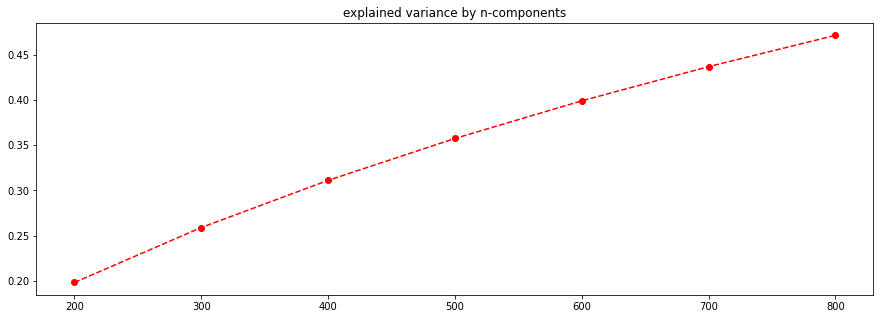

In [ ]:
import matplotlib.pyplot as plt
performance = []

test = [200, 300, 400, 500, 600, 700, 800]

for n in test:
    svd = TruncatedSVD(n_components=n)
    lsa = svd.fit(tfidf_matrix)
    performance.append(lsa.explained_variance_ratio_.sum())

fig = plt.figure(figsize=(15, 5))
plt.plot(test, performance, 'ro--')
plt.title('explained variance by n-components');

# Código retirado de: https://stackoverflow.com/questions/69091520/determine-the-correct-number-of-topics-using-latent-semantic-analysis

In [ ]:
import numpy as np

# Método Elbow, que será utilizado novamente e explicado posteriormente
test[np.abs(np.gradient(np.gradient(performance))).argmax()]

400

Com o resultado encontrado, reduziu-se a dimensionalidade da matriz para as análises posteriores:

In [ ]:
transformer = TruncatedSVD(n_components=400)
svd_reduced_matrix = transformer.fit_transform(tfidf_matrix)

Apesar do estudo prévio para a escolha do número de componentes principais para o SVD, a partir de resultados experimentais, percebeu-se que superiores a 200 apresentavam resultados próximos após o agrupamento. Já em valores pequenos (entre 2 e 100), o resultado final não era satisfatório, encontrando pouca relação entre as descrições e os gêneros.

Mesmo com a afirmação sobre os resultados referentes à dimensões superiores a 200, ainda sim é interessante que a dimensão da matriz TF-IDF seja reduzida, pois a quantidade expressiva de dados posteriormente pode causar estouro na memória e dificultar a execução dos algoritmos.

# K-Means

O primeiro algoritmo de agrupamento selecionado para a análise dos dados é o K-Means.

Para escolhermos um número de grupos que pontecialize o resultado final do agrupamento, utilizaremos o método Elbow.

## O Método Elbow

O método Elbow testa a variância dos dados em relação ao número de grupos escolhidos para a aplicação do K-Means. Uma quantidade boa de grupos é identificado quando seu aumento não representa um nível significativo de ganho.

Observando graficamente, deve-se encontrar o valor em que a grandeza praticamente se estabiliza, de forma que após ele a variância não seja discrepante:

In [ ]:
!pip install yellowbrick

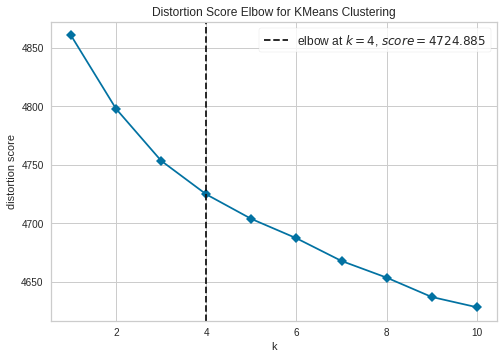

In [ ]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

model = KMeans()
visualizer = KElbowVisualizer(model, k=(1, 11), locate_elbow=True, timings=False)

visualizer.fit(svd_reduced_matrix)       
visualizer.show()

Percebe-se que acima de 4 grupos a variância já passa a ser amenizada em relação aos valores anteriores. Assim, aplica-se o K-Means nos dados para realizar o agrupamento:

In [ ]:
kmeans = KMeans(n_clusters=4)

kmeans.fit(svd_reduced_matrix)

y_kmeans = kmeans.predict(svd_reduced_matrix)

Cria-se um dataframe com a descrição e o label de cada livro agrupado para fins de avaliação dos grupos:

In [ ]:
d = {'cluster': y_kmeans, 'description': samples['description'].values, 'label': samples['label'].values}
df = pd.DataFrame(data=d)
df

,cluster,description,label
0,2,"[elli, boyfriend, interest, best, friend, magd...",children
1,0,"[charm, retel, magic, tale, power, justic, not...",children
2,0,"[georg, harold, usual, trick, last, time, hypn...",children
3,0,"[halloween, deckawoo, drive, mr, mr, watson, d...",children
4,2,"[jessica, wakefield, nt, know, surviv, long, w...",children
...,...,...,...
15995,0,"[young, age, lil, j, skin, start, steal, pain,...",young_adult
15996,0,"[ruthless, murder, stolen, shipment, gold, sch...",young_adult
15997,2,"[night, like, board, icaru, catastroph, strike...",young_adult
15998,2,"[like, father, like, son, intellig, popular, h...",young_adult


Com auxílio novamente da nuvem de palavras, é possível observar as palavras mais presentes em cada um dos grupos:

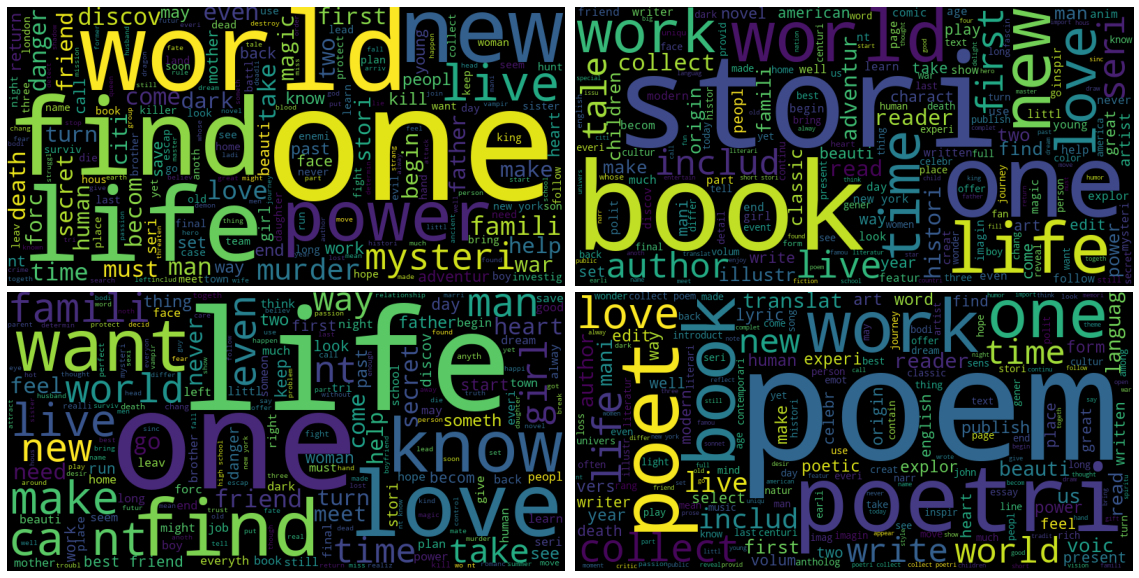

In [ ]:
#@title 
from wordcloud import WordCloud

plt.figure(figsize=(16,8), facecolor = None, frameon = False)

for t in range(4):
  mask = (df['cluster'] == t)
  unique_string = (" ").join(df[mask].description.sum())
  wordcloud = WordCloud(width=800, height=400).generate(unique_string)
  i = t + 1
  plt.subplot(2, 2, i)
  plt.plot()
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout(pad = 0.5)
plt.show()

Pode-se analisar também os gêneros presentes em cada grupo, buscando identificar predominâncias:

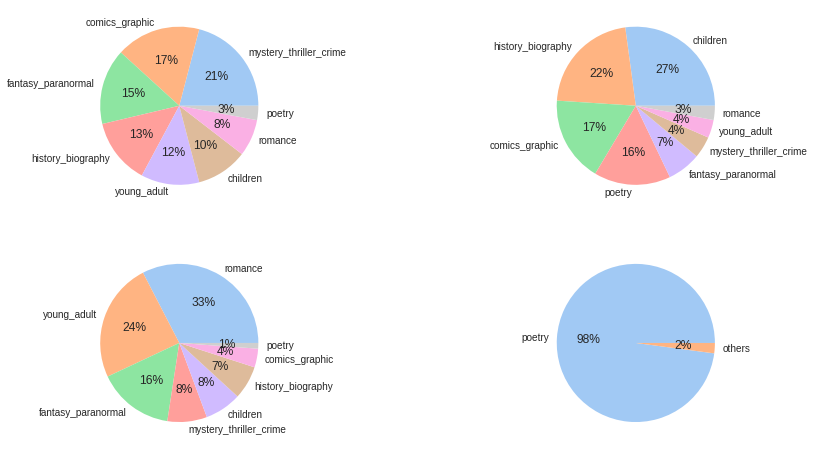

In [ ]:
#@title 

import seaborn as sns

plt.figure(figsize=(15,8))
colors = sns.color_palette('pastel')[0:8]

for i in range(4):
  mask = (df['cluster'] == i)
  labels = df[mask]['label'].value_counts().keys().tolist()
  counts = df[mask]['label'].value_counts().tolist()
  t = i + 1
  plt.subplot(2, 2, t)
  if len(counts) > 1 and counts[0] > 3 * sum(counts[1:]):
    counts[1] = sum(counts[1:])
    labels[1] = 'others'
    plt.pie(counts[0:2], labels = labels[0:2], colors = colors, autopct='%.0f%%')
  else:
    plt.pie(counts, labels = labels, colors = colors, autopct='%.0f%%')
  
plt.show()

Experimentalmente foram testados os valores 5 e 6 para a quantidade de grupos, entretando os resultados não apresentaram relações mais claras nos grupos.

# Agrupamento Hierárquico

O segundo agrupamento realizado para analisar os dados é o Agrupamento Hierárquico.

Antes de aplicar o algoritmo, é interessante que uma análise acerca do número 
de grupos seja realizada. Dessa forma, criou-se um dendograma para facilitar a visualização.

## Dendograma

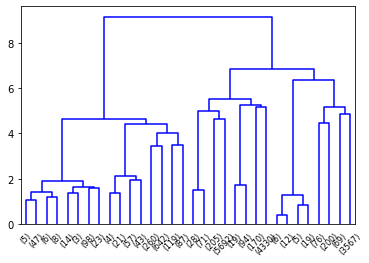

In [ ]:
import scipy.cluster
import scipy.cluster.hierarchy as hierarchy
Z = hierarchy.linkage(svd_reduced_matrix, method='ward')
hierarchy.dendrogram(Z, color_threshold=0.3, truncate_mode="level", p=4);

Com o dendograma gerado, percebe-se que existe menor espaçamento entre grupos depois que a divisão alcança 4 ramificações, e após a quinta já torna-se de difícil percepção o corte do gráfico. Assim, podemos cortar o eixo y para ampliar a visualização:

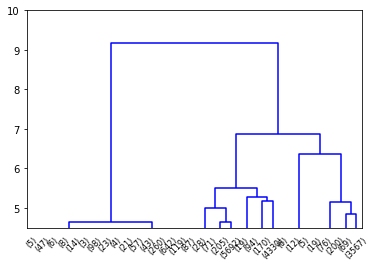

In [ ]:
#@title 
import matplotlib.pyplot as plt

hierarchy.dendrogram(Z, color_threshold=0.3, truncate_mode="level", p=4);
plt.ylim((4.5, 10))
plt.show()

Baseado em resultados experimentais, observou-se que os resultados com 4 grupos eram consideravelmente inferiores aos encontrados com 5 grupos. Dessa forma, considerando que o gráfico também indica um resultado favorável, optou-se por aplicar o agrupamento hierárquico para 5 grupos:

In [ ]:
from sklearn.cluster import AgglomerativeClustering
import numpy as np

n_groups = 5

m = AgglomerativeClustering(n_groups, linkage = 'ward')
m.fit(svd_reduced_matrix);

y_hierarchy = m.fit_predict(svd_reduced_matrix)

np.unique(m.labels_, return_counts=True)

(array([0, 1, 2, 3, 4]), array([4613, 5996, 3912,   42, 1437]))

O parâmetro `linkage = 'ward'` foi escolhido após uma série de experimentações entre os disponíveis e foi o que apresentou melhores resultados.

Pela saída do último comando, percebe-se a presença de quatro grandes grupos e um menor.

Criou-se um novo dataframe (dessa vez com a variável `df2` para que os resultados dos agrupamentos possam ser comparados mais à frente) com a saída do algoritmo:

In [ ]:
d = {'cluster': m.labels_, 'description': samples['description'].values, 'label': samples['label'].values}
df2 = pd.DataFrame(data=d)
df2

,cluster,description,label
0,1,"[elli, boyfriend, interest, best, friend, magd...",children
1,0,"[charm, retel, magic, tale, power, justic, not...",children
2,0,"[georg, harold, usual, trick, last, time, hypn...",children
3,1,"[halloween, deckawoo, drive, mr, mr, watson, d...",children
4,1,"[jessica, wakefield, nt, know, surviv, long, w...",children
...,...,...,...
15995,1,"[young, age, lil, j, skin, start, steal, pain,...",young_adult
15996,1,"[ruthless, murder, stolen, shipment, gold, sch...",young_adult
15997,0,"[night, like, board, icaru, catastroph, strike...",young_adult
15998,0,"[like, father, like, son, intellig, popular, h...",young_adult


Criou-se uma nuvem de palavras para cada grupo:

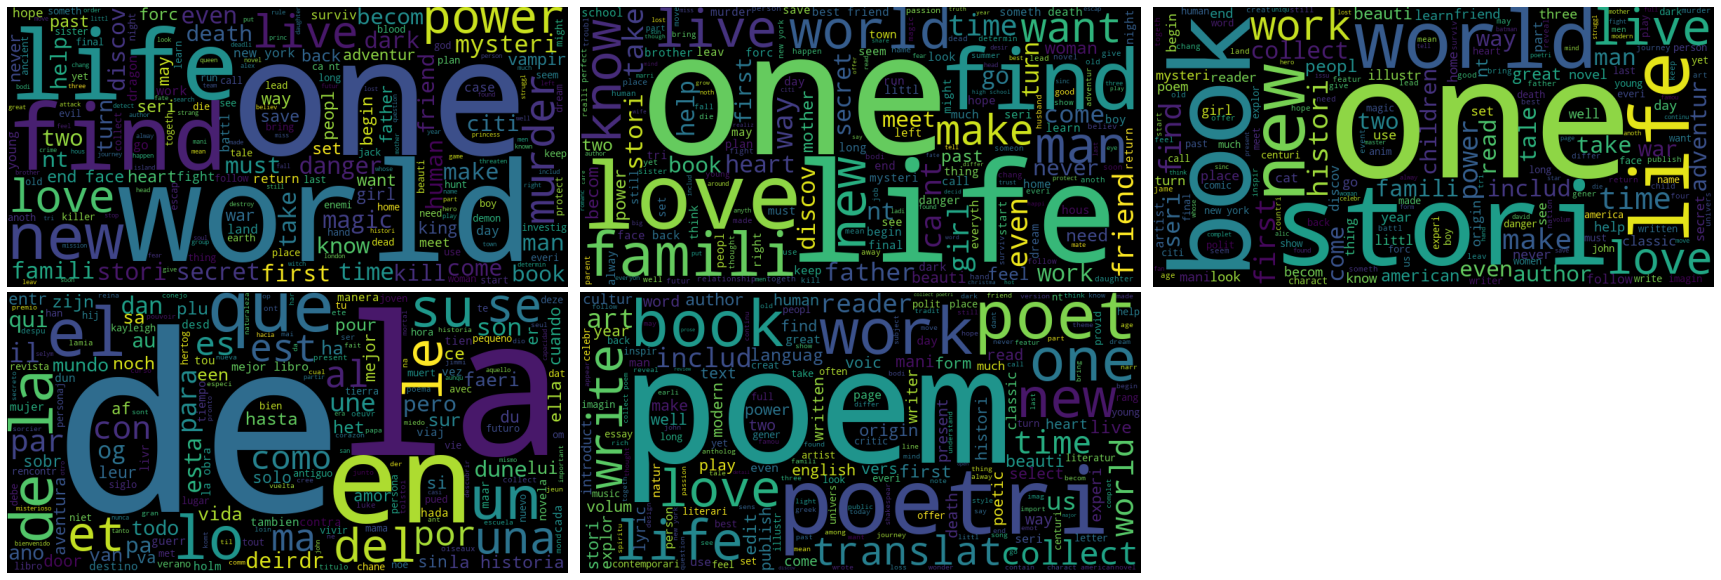

In [ ]:
#@title 
from wordcloud import WordCloud

plt.figure(figsize=(24, 8), facecolor=None, frameon=False)

for t in range(n_groups):
  mask = (df2['cluster'] == t)
  unique_string = (" ").join(df2[mask].description.sum())
  wordcloud = WordCloud(width=800, height=400).generate(unique_string)
  i = t + 1
  plt.subplot(2, 3, i)
  plt.plot()
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout(pad = 0.5)
plt.show()

Por fim, plotou-se um gráfico representando cada grupo:

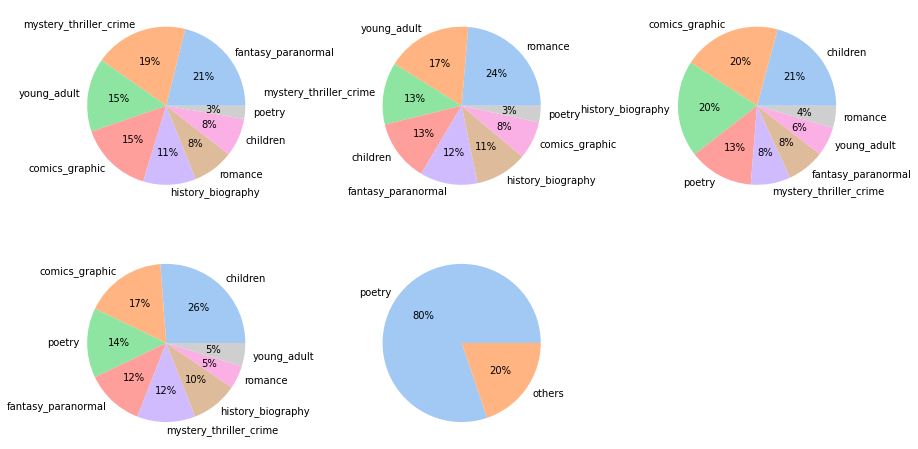

In [ ]:
#@title 
import seaborn as sns

plt.figure(figsize=(15,8))
colors = sns.color_palette('pastel')[0:8]

for i in range(n_groups):
  mask = (df2['cluster'] == i)
  labels = df2[mask]['label'].value_counts().keys().tolist()
  counts = df2[mask]['label'].value_counts().tolist()
  t = i + 1
  plt.subplot(2, 3, t)

  if len(counts) > 1 and counts[0] > 3 * sum(counts[1:]):
    counts[1] = sum(counts[1:])
    labels[1] = 'others'
    plt.pie(counts[0:2], labels = labels[0:2], colors = colors, autopct='%.0f%%')
  else:
    plt.pie(counts, labels = labels, colors = colors, autopct='%.0f%%')

plt.show()

Experimentalmente, realizou-se testes para 6 e 7 grupos, mas mesmo assim os resultados mais consistentes foram os apresentados acima.

# Análise

## Há diferença nas distribuições de gêneros literários em grupos diferentes?

Pelo agrupamento realizado a partir do K-means, observamos que o gênero poetry foi bem agrupado em relação aos demais, pois em diversas execuções a porcentagem de aparição em um só cluster sempre se manteve acima dos 90%. Destaca-se também o cluster em que romance e young_adult constituem mais da metade, pois são gêneros em que é imaginável uma semelhança, tanto da descrição quanto do conteúdo.

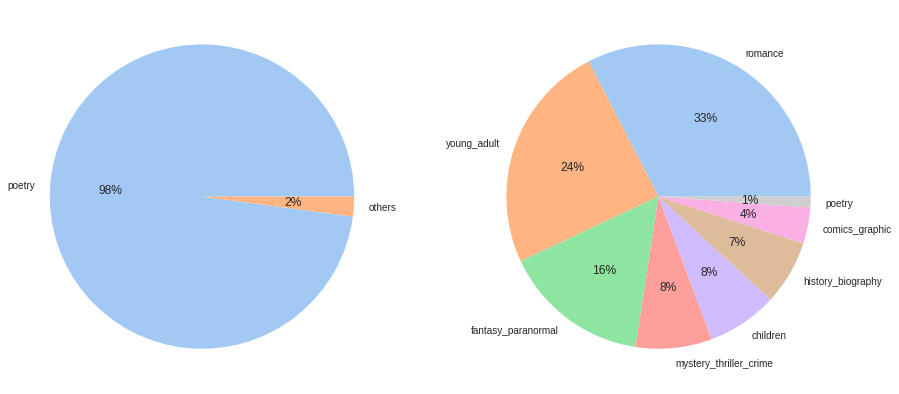

In [ ]:
#@title 

plt.figure(figsize=(15,8))
colors = sns.color_palette('pastel')[0:8]

t = 1
clusters = [3, 2]

for i in clusters:
  mask = (df['cluster'] == i)
  labels = df[mask]['label'].value_counts().keys().tolist()
  counts = df[mask]['label'].value_counts().tolist()
  plt.subplot(1, 2, t)

  if len(counts) > 1 and counts[0] > 3 * sum(counts[1:]):
    counts[1] = sum(counts[1:])
    labels[1] = 'others'
    plt.pie(counts[0:2], labels = labels[0:2], colors = colors, autopct='%.0f%%')
  else:
    plt.pie(counts, labels = labels, colors = colors, autopct='%.0f%%')
  
  t += 1
  
plt.show()

No agrupamento hierárquico, percebe-se também a predominância do gênero poetry em um cluster, além de também encontrarmos forte presença de romance e young_adult em outro. Entretanto, obteve-se resultados interessantes também nos gêneros comics_graphics e children, que foram bem destacados juntos em dois grupos diferentes.



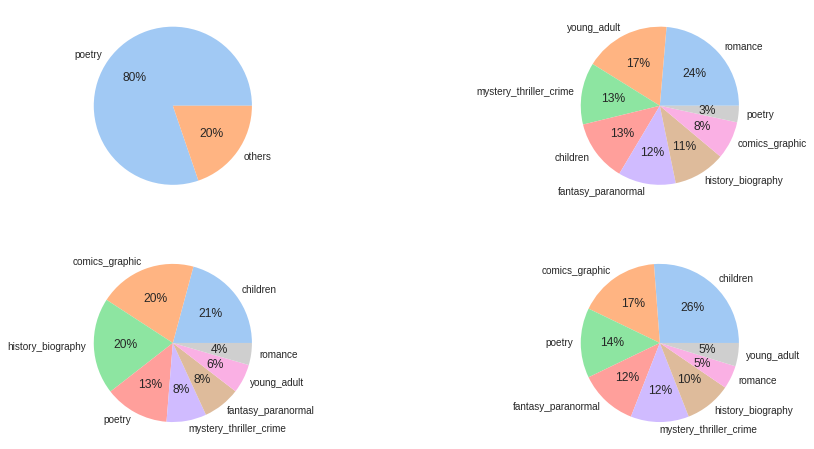

In [ ]:
#@title 

plt.figure(figsize=(16,8))
colors = sns.color_palette('pastel')[0:8]

t = 1
clusters = [4, 1, 2, 3]

for i in clusters:
  mask = (df2['cluster'] == i)
  labels = df2[mask]['label'].value_counts().keys().tolist()
  counts = df2[mask]['label'].value_counts().tolist()
  plt.subplot(2, 2, t)

  if len(counts) > 1 and counts[0] > 3 * sum(counts[1:]):
    counts[1] = sum(counts[1:])
    labels[1] = 'others'
    plt.pie(counts[0:2], labels = labels[0:2], colors = colors, autopct='%.0f%%')
  else:
    plt.pie(counts, labels = labels, colors = colors, autopct='%.0f%%')
  
  t += 1
  
plt.show()

Podemos afirmar assim que existe diferença na distribuição de gêneros literários em grupos diferentes, sendo evidenciada fortemente pelo gênero `poetry` e também visível em `romance` e `young_adult` nos dois agrupamentos realizados. Individualmente, a diferença observada nos gêneros `children` e `comics_graphic` no agrupamento hierárquico também reforça a afirmação.

## Há relação entre as descrições dos livros e os gêneros literários?

Com os resultados obtidos nos agrupamentos, verificou-se que **existe sim uma relação entre a descrição dos livros e o gênero literário correspondente**, mesmo que não seja tão evidente em boa parte dos gêneros.

Podemos observar como resultado dos dois agrupamentos que o gênero poetry foi agrupado com base na predominância dos mesmos termos na descrição nos dois algoritmos, como indicam as nuvens de palavras:

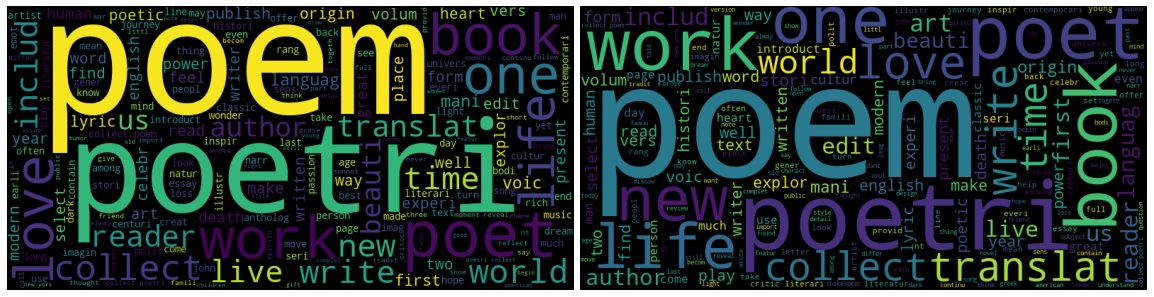

In [ ]:
#@title 

plt.figure(figsize=(16, 8), facecolor=None, frameon=False)

mask = (df['cluster'] == 3)
unique_string = (" ").join(df[mask].description.sum())
wordcloud = WordCloud(width=800, height=400).generate(unique_string)
plt.subplot(1, 2, 1)
plt.plot()
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0.5)

mask = (df2['cluster'] == 4)
unique_string = (" ").join(df2[mask].description.sum())
wordcloud = WordCloud(width=800, height=400).generate(unique_string)
plt.subplot(1, 2, 2)
plt.plot()
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0.5)

plt.show()

No resultado do K-means, vale o destaque para o cluster com predominância de fantasy_paranormal, mystery_thriller_crime e comics_graphic, três gêneros com maior proximidade de enredos com ação ou ficção. É possível observar termos como `mistery`, `death` e `murder`, enfatizando assim a relação entre os gêneros e o agrupamento:

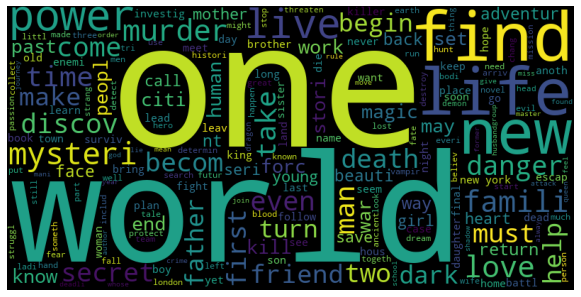

In [ ]:
#@title
plt.figure(figsize=(16, 8), facecolor=None, frameon=False)

mask = (df['cluster'] == 0)
unique_string = (" ").join(df[mask].description.sum())
wordcloud = WordCloud(width=800, height=400).generate(unique_string)
plt.subplot(1, 2, 1)
plt.plot()
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0.5)

No agrupamento hierárquico observou-se um resultado interessante nos termos predominantes de um dos clusters com forte presença dos gêneros children e comics_graphic. Termos característicos do gênero, como `adventure`, `power` e até mesmo `children`, são facilmente identificados na nuvem de palavras, reforçando assim a influência das palavras contidas na descrição para o agrupamento dos dados:

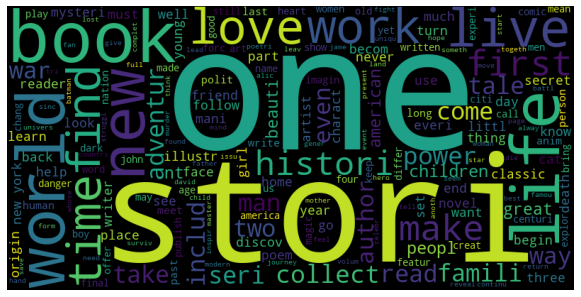

In [ ]:
#@title 

plt.figure(figsize=(16, 8), facecolor=None, frameon=False)

mask = (df2['cluster'] == 2)
unique_string = (" ").join(df2[mask].description.sum())
wordcloud = WordCloud(width=800, height=400).generate(unique_string)
plt.subplot(1, 2, 1)
plt.plot()
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0.5)

plt.show()

Já no outro cluster em que esses gêneros estão bem presentes, caso tivéssemos realizado a análise exclusivamente pelo gráfico de pizza poderíamos obter conclusões errôneas. Percebemos que a nuvem de palavras contém diversos termos que aparentam ser "intrusos" na análise, visto que realiza-se um filtro inicial para selecionar livros na língua inglesa e conseguimos observar termos derivados do latim, como `cuando`, `mejor` e `libro`. Apesar de não contribuir parar descobrir o gênero do livro, isso pode demonstrar que o agrupamento hierárquico foi capaz de separar outliers, provando também certo valor.

# Conclusão

Dessa forma, conclui-se que a análise realizada nos dados obteve resultados satisfatórios. Percebeu-se que a aplicação de diferentes algoritmos com a mesma finalidade (agrupamento) também pôde gerar resultados significamente diferentes.

A começar pelo número de grupos, o estudo realizado anteriormente à aplicação de cada algoritmo sinalizou um número diferente de grupos a serem formados em cada agrupamento. A escolha de um grupo a mais no agrupamento hierárquico possibilitou com que o grupo em que os gêneros comics_graphic e children se destacaram aparecesse, constituindo um bom resultado.

Pode-se afirmar também que o resultado obtido com poetry evidencia uma relação forte entre o gênero e a descrição desses livros, visto que nos dois algoritmos obteve-se como resultado um cluster com a grande maioria dos livros sendo do gênero especificado.

Assim, percebe-se que a escolha do algoritmo impacta diretamente na formação e eventualmente na quantidade de grupos, mas que relações fortes (como a observada no gênero poetry) tendem a serem percebidas com mais regularidade em métodos diferentes.